#### Imports & Downloads

In [ ]:
!pip install autocorrect
!pip install textblob
!pip install symspellpy
!pip install pyaspell
!pip install fuzzywuzzy
!pip install hunspell
!pip install better_profanity

In [2]:
import os
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../../../1. Explorative Analysis & Preprocessing/nasiba/'))
os.chdir(src_path) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
from nltk.corpus import stopwords, wordnet
import time
from pathlib import Path

from collections import Counter
from spellchecker import SpellChecker
import os

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from nltk.stem import WordNetLemmatizer
from ftfy import fix_encoding
import spacy
from src.preprocessing.cleaning.shotcut_lists import shortcuts
#nlp = spacy.load("en_core_web_sm")
import pandas as pd
pd.set_option('display.max_colwidth', None)

### Einladen der Daten

In [4]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train.csv'))
df_origin = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)


## 1. Datenexploration

### 1.1 Datenqualitätsüberprüfung generell

In [5]:
df_origin.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation


In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


In [7]:
# Check for null values
df_origin.isna().sum()

# no null's

label    0
tweet    0
dtype: int64

In [8]:
# check for duplicates
print(df_origin.duplicated().sum())

2432


### 1.2 Text Qualität Checks

In [9]:
df_raw = df_origin.copy()

##### 1.2.1 Überprüfung von stopwords

In [10]:
# which words are actually stop words?
stop_words = set(stopwords.words('english'))

stop_words_list = list(stop_words)
print(stop_words_list)

['no', 'be', 'd', 'himself', 'over', 'how', 'same', 'o', 'between', 'there', 'until', 'needn', 'a', "doesn't", "weren't", 'any', 'whom', 'down', 'an', 'most', 'wasn', 'for', 'where', 'these', 'ourselves', 'under', 'against', 'then', 'up', 'each', "didn't", 'their', 'but', 'from', 'haven', "you've", 'once', 'you', "you'll", 'did', "mightn't", 'the', 'further', 'yourself', 'why', 'yours', 'of', 'hadn', "isn't", "hadn't", "wouldn't", 'm', 'all', 'own', "should've", 'too', 'it', 'being', "you'd", "that'll", 'when', 'few', 'will', 'with', 'those', 'he', 'theirs', 'have', 'don', 'ma', 'which', 'at', "shouldn't", 'who', 'does', 'my', 'weren', 'her', 'some', 't', 'again', 'as', "you're", 'y', 'them', 'we', 'am', 'because', 'after', 'to', 'mustn', 'themselves', 'out', 'more', 'shouldn', 'll', 'should', "haven't", 'isn', "she's", 'were', 'below', 's', "couldn't", 'this', 'through', 'i', 'wouldn', 'very', 'me', 'had', 'our', 'into', 'doing', 're', 'other', 'and', 'shan', 'or', 'myself', 'been', '

In [11]:
# find stop words in tweet column
def find_stop_words(df):
    df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
    return df


df_raw = find_stop_words(df_raw)
df_raw[df_raw['stopwords'].notna()].head()

,label,tweet,stopwords
id,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,10
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5
3,0,bihday your majesty,1
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,5
5,0,factsguide: society now #motivation,1


##### 1.2.2 Überprüfung von HTML tags/ special characters

In [12]:
def find_hash_tags(df):
    df['hashtags'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    return df


df_raw = find_hash_tags(df_raw)
df_raw[df_raw['hashtags'] > 0].head()

,label,tweet,stopwords,hashtags
id,,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,10,1
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5,3
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,5,1
5,0,factsguide: society now #motivation,1,1
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,6,1


##### 1.2.3 Überprüfung von Wörtern mit Großbuchstaben

In [13]:
def find_num_uppercase(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    return df


df_raw = find_num_uppercase(df_raw)
df_raw[df_raw['upper_case'] > 0].head()


,label,tweet,stopwords,hashtags,upper_case
id,,,,,
161,0,new selfie \Â¤.Â¤/ #guy #mato #chapones,0,3,1
555,0,come on #ee piss poor reception today Â£20 a month and struggle to get a signal in #buxton put more masts up or i'm switching #grumpy,9,3,1
1109,1,"@user all happy for Ã¨ #lbgt family,but what i don't get is the incessant but thin veiled against other gay minorities?",10,1,1
1715,0,over a year after leaving @user i received a demand for Â£12. should have told me when i left! #paidnow #fuckoffnevercomingbacktosky,11,2,1
2502,0,#bahrain #youth #protesters #clash with #riot #police and #armoured #vehicles #Ø§ÙØ¨Ø­Ø±ÙÙ #Ø§ÙÙÙÙØ¯Ø±Ø§Øª,2,10,1


##### 1.2.4 Überprüfung von HTML Tags im Text

In [14]:
def identify_html_tags(text):
    pattern = re.compile('<.*?>')
    tags = pattern.findall(text)
    tag_count = len(tags)
    return tag_count

In [15]:
def find_html_tags(df):
    df['html_tag_count'] = df['tweet'].apply(lambda x: identify_html_tags(x))
    return df


df_raw = find_html_tags(df_raw)
df_raw[df_raw['html_tag_count'] > 0]
# Conclusion: no html tags

,label,tweet,stopwords,hashtags,upper_case,html_tag_count
id,,,,,,


In [16]:
def identify_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    urls = pattern.findall(text)
    tag_count = len(urls)
    return tag_count

##### 1.2.5 Überprüfung von URL's im Text

In [17]:
def find_urls(df):
    df['url_count'] = df['tweet'].apply(identify_urls)
    return df


df_raw = find_urls(df_raw)
df_raw[df_raw['url_count'] > 0]

,label,tweet,stopwords,hashtags,upper_case,html_tag_count,url_count
id,,,,,,,
1112,0,#fly #and #better #with #us #buranus #www.flybcc.com #call #7/24 #airbroker #flightâ¦,0,11,0,0,1
6376,0,#isitthursdayyet? it's not? awwww... #criticalrole #critter,1,3,0,0,1
8085,0,couple having sex www.drunk singapore girl get fuck,1,0,0,0,1
8485,0,so glad my #workout includes smoke breaks...www.smokeweedeatbacon.com #weed #bacon #fitness #sex #health #marijuana #strength #living,2,9,0,0,1
8661,0,@user just run 10kms for @user @user #loveisall pour donner: www.alvarum/heloiseetlespremas,2,1,0,0,1
25746,0,@user sirrr getting new one wowwww... to see this plss take care of urself...love youððâ¤ï¸â¤ï¸â¤ï¸â¤ï¸,3,0,0,0,1


##### 1.2.6 Überprüfung von oft auftretenden Wörter im Text

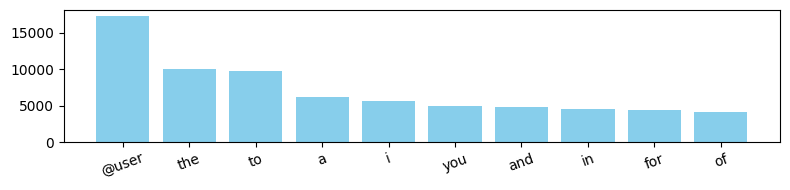

In [18]:
freq_words = pd.Series(' '.join(df_raw['tweet']).split()).value_counts()[:10]

words = freq_words.index
counts = freq_words.values
plt.figure(figsize=(8, 2))
plt.bar(words, counts, color='skyblue')

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


##### 1.2.7 Überprüfung von shortcuts/slangs im Text

In [19]:
def expand_shortcuts(text):
    new_text = []
    for w in text.split():
        if w.upper() in shortcuts:
            new_text.append(shortcuts[w.upper()])
            return new_text
        else:
            None


def find_shortcuts(df):
    df['expanded_shortcut'] = df['tweet'].apply(lambda x: expand_shortcuts(x))
    return df

In [20]:
df_raw = find_shortcuts(df_raw)
df_result = df_raw[df_raw['expanded_shortcut'].notna()]
df_result = df_result[['tweet', 'expanded_shortcut']]
df_result.head(500)

# Fehlerbehaftete Änderung, z.B. 48 "im" statt "i am" zu "Instant Message"

,tweet,expanded_shortcut
id,,
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
19,its #friday! ð smiles all around via ig user: @user #cookies make people,[Instagram]
47,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
48,#whenever im and #something goes #wrong |,[Instant Message]
97,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
...,...,...
10089,hourglass x #love #life #beautiful #picoftheday #lovelovelove #me #us #travel #peaceâ¦,[Previously Named Twitter]
10101,when u up ya request get handled off gp! #onlymoneytalks,[You]
10133,im done this gurl betta get my faceððð,[Instant Message]


##### 1.2.7 Überprüfung von emojis im Text

In [21]:
def is_emoji(word):
    try:
        converted = word.encode('latin1').decode('utf-8')
        return any(emoji.is_emoji(char) for char in converted)
    except (UnicodeEncodeError, UnicodeDecodeError):
        return False

    return any(emoji.is_emoji(char) for char in word)


def find_emojis(df):
    df['has_emoji'] = df['tweet'].apply(lambda x: is_emoji(x))
    return df


df_raw = find_emojis(df_raw)
df_raw[["tweet", "has_emoji"]].head(15)

,tweet,has_emoji
id,,
1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,False
2,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,False
3,bihday your majesty,False
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,True
5,factsguide: society now #motivation,False
6,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,False
7,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,False
8,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,True
9,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,False


##### 1.2.8 Überprüfung von falsch geschriebenen Wörtern im Text

In [22]:
spell = SpellChecker()


def identify_misspelled_words(text):
    text = re.sub(r".*[_.!$%^&*()<>?/\|}{~:].*", '', text)
    try:
        converted = text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        converted = text
    words = converted.split()

    misspelled = [
        word for word in words
        if not any(emoji.is_emoji(char) for char in word)  # Ignoriere Emojis
           and not word.startswith('@')  # Ignoriere Wörter, die mit @ beginnen
           and not word.startswith('#')  # Ignoriere Wörter, die mit # beginnen
           and word in spell.unknown([word])  # Führe Rechtschreibprüfung auf verbleibende Wörter durch
           and not word.endswith('!')
           and not word.endswith(']')
           and not word.startswith('[')
    ]
    return misspelled


def find_misspelled_words(df):
    df['misspelled_words'] = df['tweet'].apply(identify_misspelled_words)
    return df


df_raw = find_misspelled_words(df_raw)
df_raw[['tweet', 'misspelled_words']]

,tweet,misspelled_words
id,,
1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,[]
2,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,[]
3,bihday your majesty,[bihday]
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[]
5,factsguide: society now #motivation,[]
...,...,...
31958,ate @user isz that youuu?ðððððððððâ¤ï¸,[]
31959,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,[]
31960,listening to sad songs on a monday morning otw to work is sad,"[monday, otw]"


##### 1.2.9 Überprüfung Anzahl der Wörter in Tweets

In [23]:
def word_count(df):
    df['count_of_words'] = df['tweet'].apply(lambda x: len(str(x).split(" ")))
    return df


df_raw = word_count(df_raw)

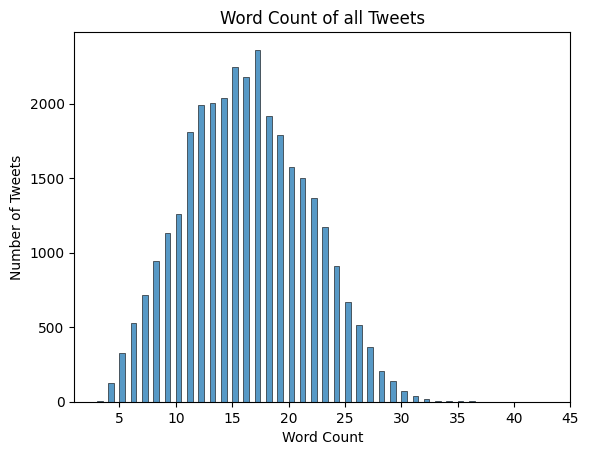

<Figure size 400x200 with 0 Axes>

In [24]:
df_raw = word_count(df_raw)

sns.histplot(df_raw['count_of_words'])

plt.title('Word Count of all Tweets')

plt.xlabel('Word Count')
plt.ylabel('Number of Tweets')
plt.figure(figsize=(4, 2))
plt.show()

### 1.3 Ausreißerprüfung

In [25]:
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

find_outlier(df_raw[['count_of_words']])


Column:  count_of_words
Mean:  16.048182216381953 ; Std:  5.395800656851071
Outlier:  24 ; Values:  [33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 38, 39, 40, 42, 43]


In [27]:
porter = PorterStemmer()
snow = SnowballStemmer("english")
word_net = WordNetLemmatizer()


def find_words(col):
    cnt = Counter()
    for text in col.values:
        for word in text.split():
            word = re.sub('[^A-Za-z]+', '', word)
            if len(word) == 7:
                cnt[word] += 1

    return cnt


counter = find_words(df_raw["tweet"])
words = set([w for (w, wc) in counter.most_common(100)])